# Clustering of Credit Card Users

MARIANO, Isaiah John L.

REGALARIO, Jeremiah Daniel A.

In [1]:
# Colab
'''from google.colab import drive
drive.mount('/content/drive')'''

"from google.colab import drive\ndrive.mount('/content/drive')"

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import sklearn

from datetime import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

try:
    from kneed import KneeLocator
except:
    !pip install kneed
    from kneed import KneeLocator


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Clustering Algorithm

## Load the Merged Dataset

In [2]:
#colab
'''
#Enter dataset here
dataset = "minmax_binned_scaled_all_except_long_lat_df.parquet"

cluster_df = pd.read_parquet("/content/drive/MyDrive/BPI Clustering Project/Scaled Datasets/{i}.parquet".format(i = dataset))
cluster_df.head()
'''

#local

#Enter dataset here
dataset = "minmax_binned_scaled_all_except_long_lat_df.parquet"

cluster_df = pd.read_parquet(dataset)
cluster_df.head()

EDUCATION       AGE    TENURE  BUSINESS_OWNER  DIGITAL_FLAG  \
CUST_NUM                                                                    
13401.256807        0.5  0.151163  0.031125             0.0           0.0   
4230.004965         0.0  0.139535  0.255402             0.0           0.0   
4481.937304         0.0  0.151163  0.218675             0.0           0.0   
4734.959768         0.0  0.151163  0.101645             0.0           0.0   
4828.128416         0.5  0.151163  0.146732             0.0           0.0   

              SUBSEGMENT   LATITUDE   LONGITUDE  INCOME_SOURCE_ALLOWANCE  \
CUST_NUM                                                                   
13401.256807    0.000000  15.527737  120.419269                    False   
4230.004965     0.666667  14.608637  121.031947                     True   
4481.937304     0.666667  14.608637  121.031947                    False   
4734.959768     0.000000  14.608637  121.031947                    False   
4828.128416     0.333333  14.608637  121.031947                    False   

              INCOME_SOURCE_BUSINESS  INCOME_SOURCE_COMMISSION  \
CUST_NUM                                                         
13401.256807                   False                     False   
4230.004965                    False                     False   
4481.937304                    False                     False   
4734.959768                    False                     False   
4828.128416                    False                     False   

              INCOME_SOURCE_DONATION  INCOME_SOURCE_ECONOMICALLY_INACTIVE  \
CUST_NUM                                                                    
13401.256807                   False                                False   
4230.004965                    False                                False   
4481.937304                    False                                False   
4734.959768                    False                                False   
4828.128416                    False                                False   

              INCOME_SOURCE_INTEREST_SAVINGS_PLACEMENTS_INVESTMENTS  \
CUST_NUM                                                              
13401.256807                                              False       
4230.004965                                               False       
4481.937304                                               False       
4734.959768                                               False       
4828.128416                                               False       

              INCOME_SOURCE_OTHER_SOURCES_NOT_SPECIFIED  \
CUST_NUM                                                  
13401.256807                                      False   
4230.004965                                       False   
4481.937304                                       False   
4734.959768                                       False   
4828.128416                                       False   

              INCOME_SOURCE_PENSION  INCOME_SOURCE_REMITTANCE  \
CUST_NUM                                                        
13401.256807                  False                     False   
4230.004965                   False                     False   
4481.937304                   False                     False   
4734.959768                   False                     False   
4828.128416                   False                      True   

              INCOME_SOURCE_SALARY  GENDER_FEMALE  GENDER_MALE  GENDER_OTHERS  \
CUST_NUM                                                                        
13401.256807                  True          False         True          False   
4230.004965                  False          False         True          False   
4481.937304                   True           True        False          False   
4734.959768                   True           True        False          False   
4828.128416                  False           True        False          False   

  

## K-means with PCA

### PCA

#### Cumulative Explained Variance Ratio

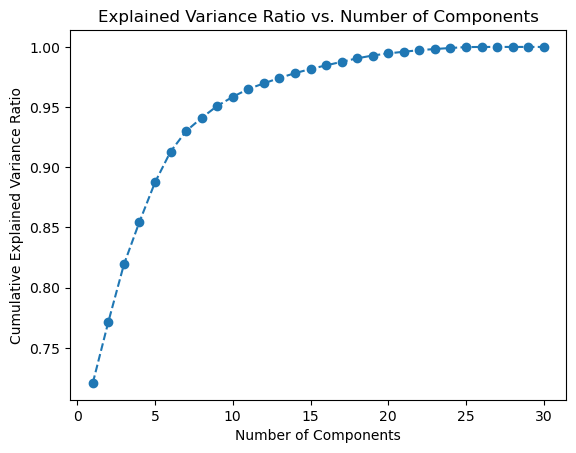

In [3]:
pca = PCA()
pca.fit(cluster_df)
explained_variance_ratio = pca.explained_variance_ratio_

plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio.cumsum(), marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance Ratio vs. Number of Components')
plt.show()

#### Scree Plot

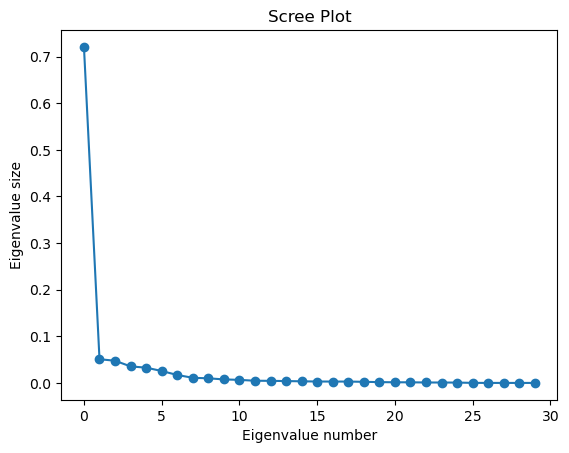

In [4]:
plt.plot(pca.explained_variance_ratio_, marker = 'o')
plt.xlabel('Eigenvalue number')
plt.ylabel('Eigenvalue size')
plt.title('Scree Plot')
plt.show()

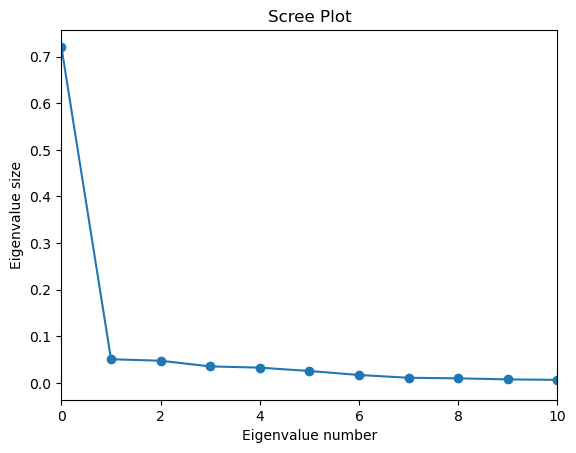

In [5]:
plt.plot(pca.explained_variance_ratio_, marker = 'o')
plt.xlabel('Eigenvalue number')
plt.ylabel('Eigenvalue size')
plt.title('Scree Plot')
plt.xlim(0, 10)
plt.show()


The "elbow point" in the plot is where the explained variance starts to level off. This is a good indicator of the number of components to retain. We chose 7 as the number of components.

#### Fit Transform

In [4]:
pca = PCA(n_components = 7)
X_principal = pca.fit_transform(cluster_df)
X_principal = pd.DataFrame(X_principal)
X_principal.columns = ['P1', 'P2','P3', 'P4','P5', 'P6','P7']

X_principal.head()

P1        P2        P3        P4        P5        P6        P7
0 -2.222108  0.827721 -0.596902 -0.517051 -0.119214  0.127624 -0.173236
1 -1.125677  0.830074 -0.597694  0.148943  0.940530  0.015140 -0.213850
2 -1.127239 -0.582931 -0.573685 -0.407654  0.038777  0.045598 -0.132528
3 -1.120412 -0.588198 -0.571587 -0.367607 -0.279692  0.057845 -0.199814
4 -1.107050 -0.597880 -0.571128  0.540362 -0.711728  0.127958 -0.520312

#### Correlation Matrix

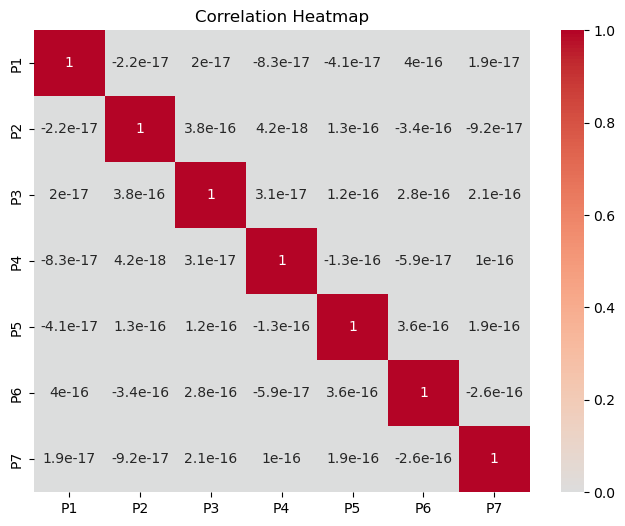

In [7]:
# Calculate the correlation matrix
corr_matrix = X_principal.corr()

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

#### Pairplot

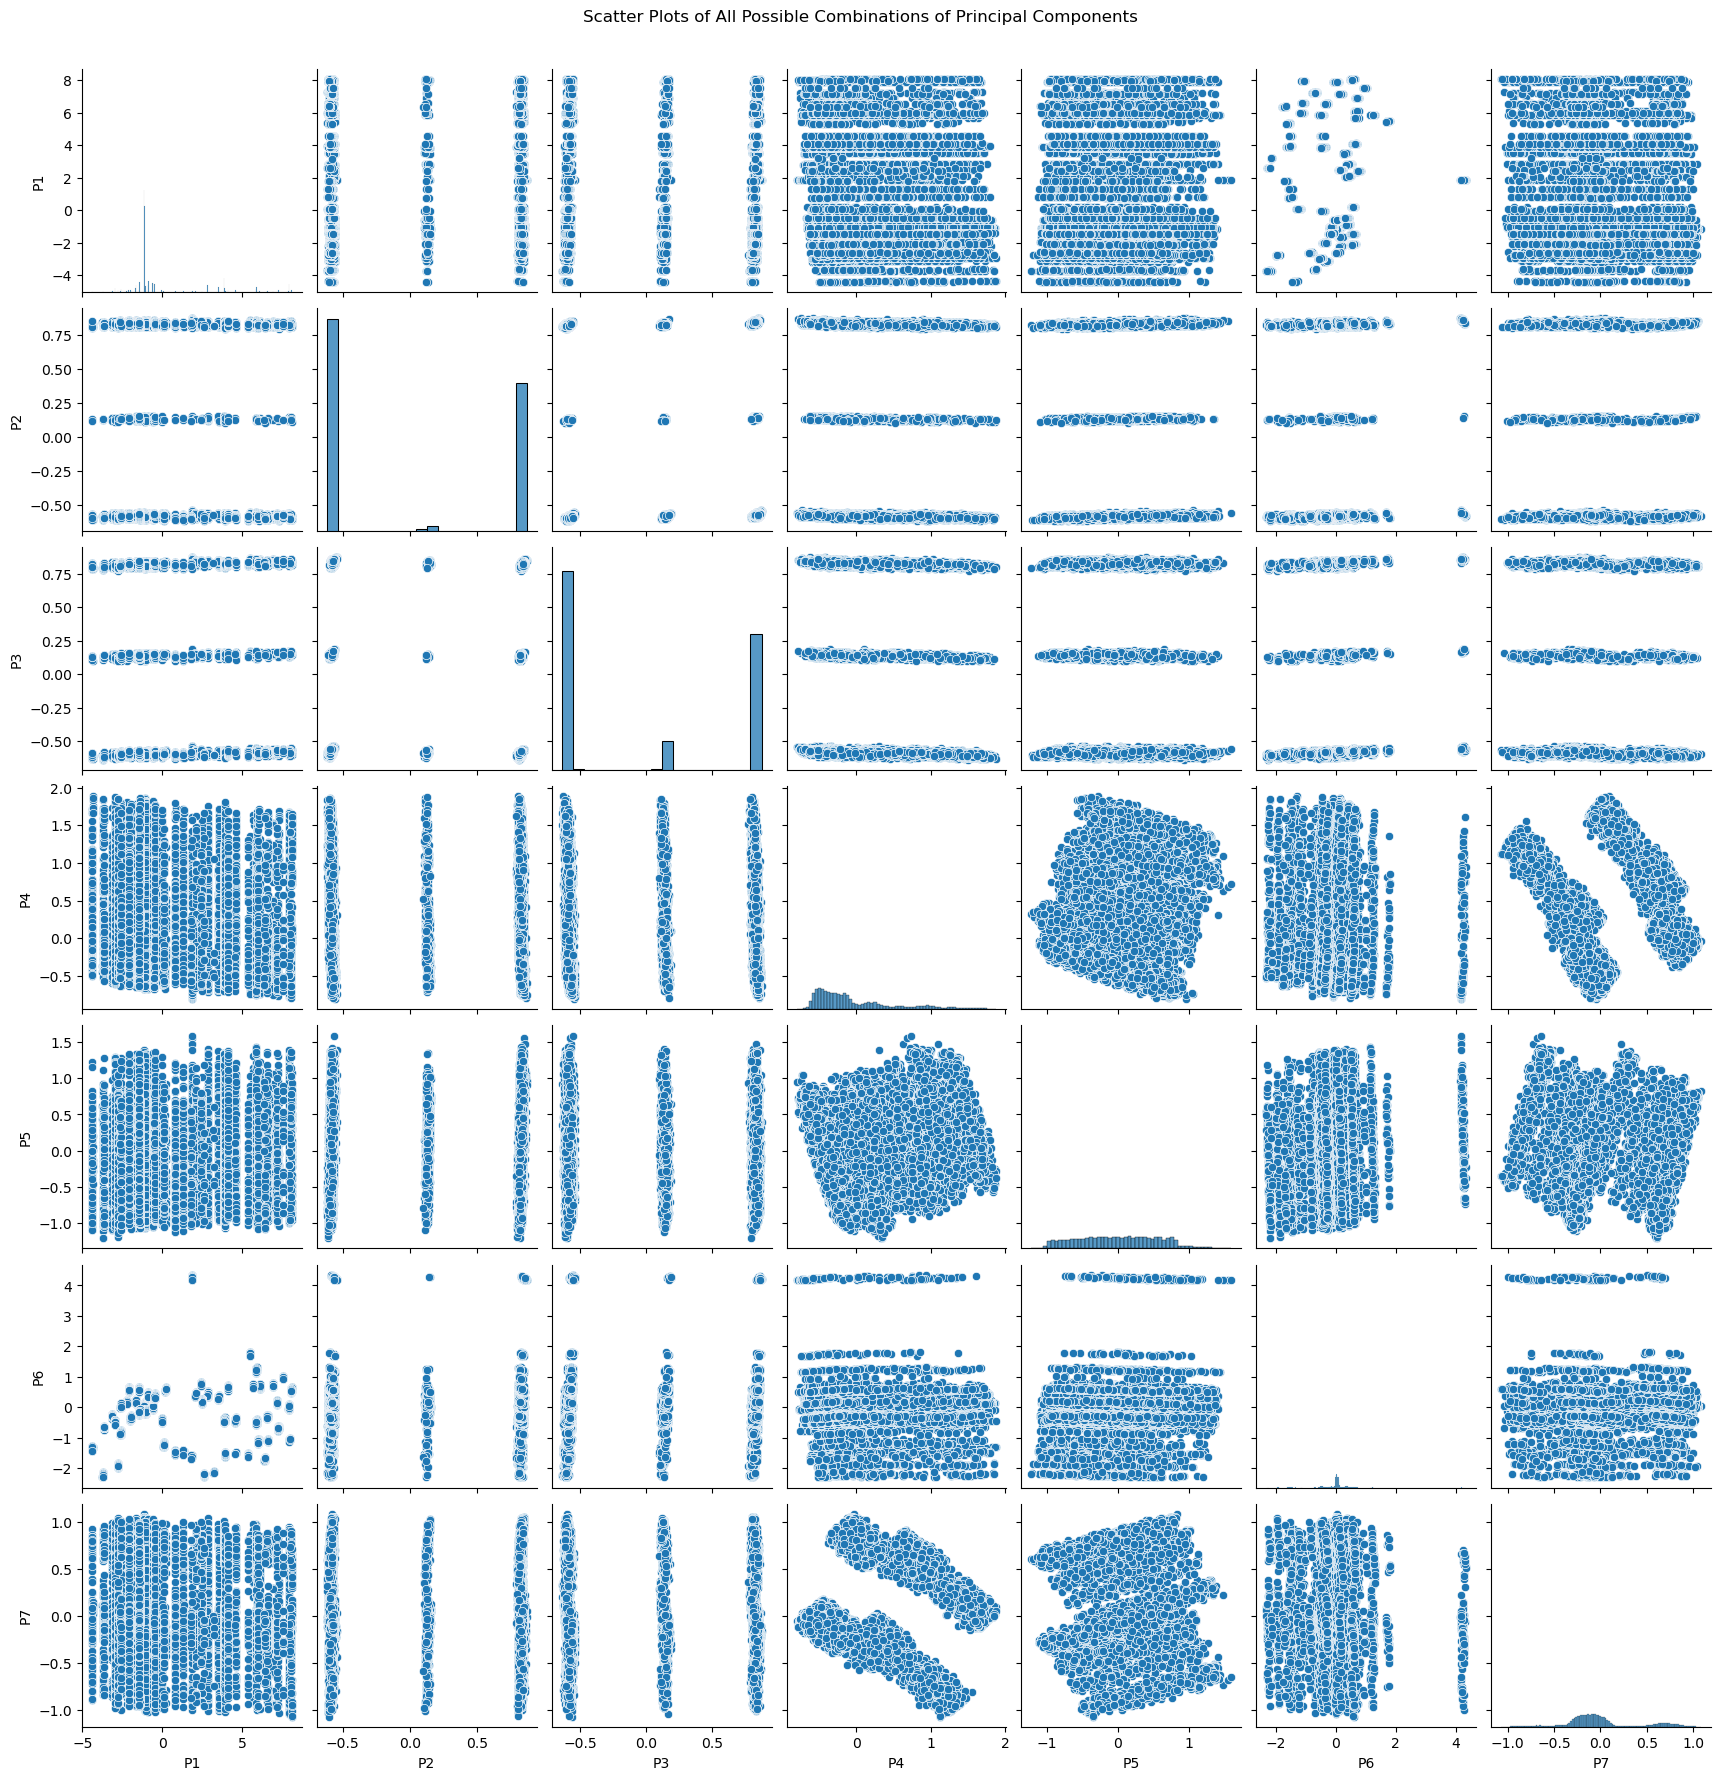

In [8]:
# Pairplot of the principal components
sns.pairplot(X_principal)
plt.suptitle('Scatter Plots of All Possible Combinations of Principal Components', y=1.02)
plt.show()

### Elbow Method and Silhouette Coefficients

#### K-means (using best parameters)

In [11]:
from sklearn.metrics import silhouette_score

kmeans_set = {'algorithm': 'lloyd', 'init': 'k-means++', 'n_init': 10, 'random_state': 42}

num_clusters = range(2,20)
inertias = []
silhouette_coefficients = []

for k in num_clusters:
    kmeans = KMeans(n_clusters=k, **kmeans_set)
    kmeans.fit(X_principal)
    inertias.append(kmeans.inertia_)
    score=silhouette_score(X_principal, kmeans.labels_)
    silhouette_coefficients.append(score)

#### Elbow Method and Silhouette Coffecients Plots

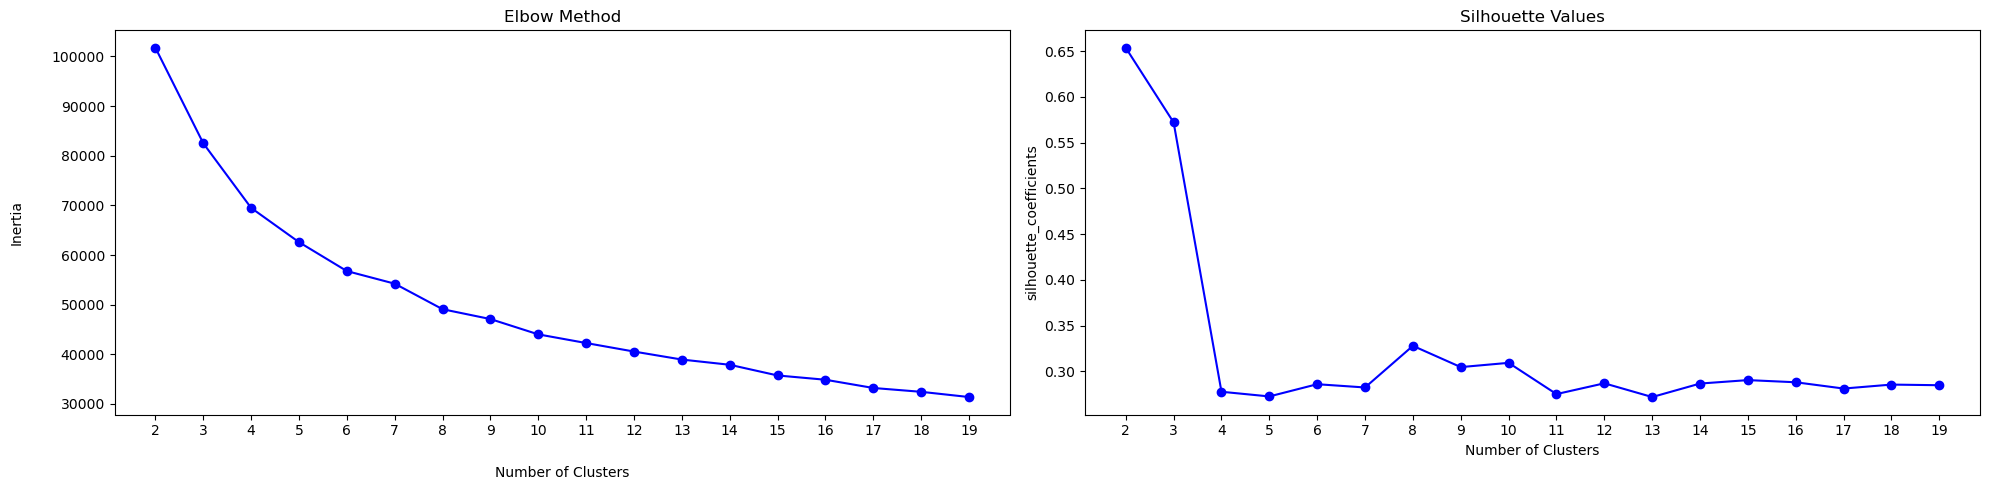

In [12]:
fig,ax=plt.subplots(1, 2, figsize=(20, 5))
kl = KneeLocator(range(2, 20), inertias, curve='convex', direction="decreasing")
ax[0].plot(range(2, 20), inertias,color='blue',marker='o',label='Elbow Method')
ax[0].set_xticks(range(2, 20))
ax[0].set_xlabel("Number of Clusters", labelpad=20)
ax[0].set_ylabel("Inertia", labelpad=20)
ax[0].set_title("Elbow Method")

ax[1].plot(range(2, 20), silhouette_coefficients, color='blue', marker='o', label='silhouette coefficients')
ax[1].set_xticks(range(2, 20))
ax[1].set_title("Silhouette Values")
ax[1].set_xlabel("Number of Clusters")
ax[1].set_ylabel("silhouette_coefficients")
plt.tight_layout()

We chose 8 as the number of clusters

### Implement K-Means using best parameters and n_cluster = 8

In [9]:
# Set number of clusters
N = 8

kmeans_set = {'algorithm': 'lloyd', 'init': 'k-means++', 'n_init': 10, "random_state": 42}
kmeans = KMeans(n_clusters=N, **kmeans_set)
kmeans.fit(X_principal)
X_principal['Cluster'] = kmeans.labels_
X_principal.head()

P1        P2        P3        P4        P5        P6        P7  \
0 -2.222108  0.827721 -0.596902 -0.517051 -0.119214  0.127624 -0.173236   
1 -1.125677  0.830074 -0.597694  0.148943  0.940530  0.015140 -0.213850   
2 -1.127239 -0.582931 -0.573685 -0.407654  0.038777  0.045598 -0.132528   
3 -1.120412 -0.588198 -0.571587 -0.367607 -0.279692  0.057845 -0.199814   
4 -1.107050 -0.597880 -0.571128  0.540362 -0.711728  0.127958 -0.520312   

   Cluster  
0        0  
1        0  
2        6  
3        6  
4        6

#### Pairplot

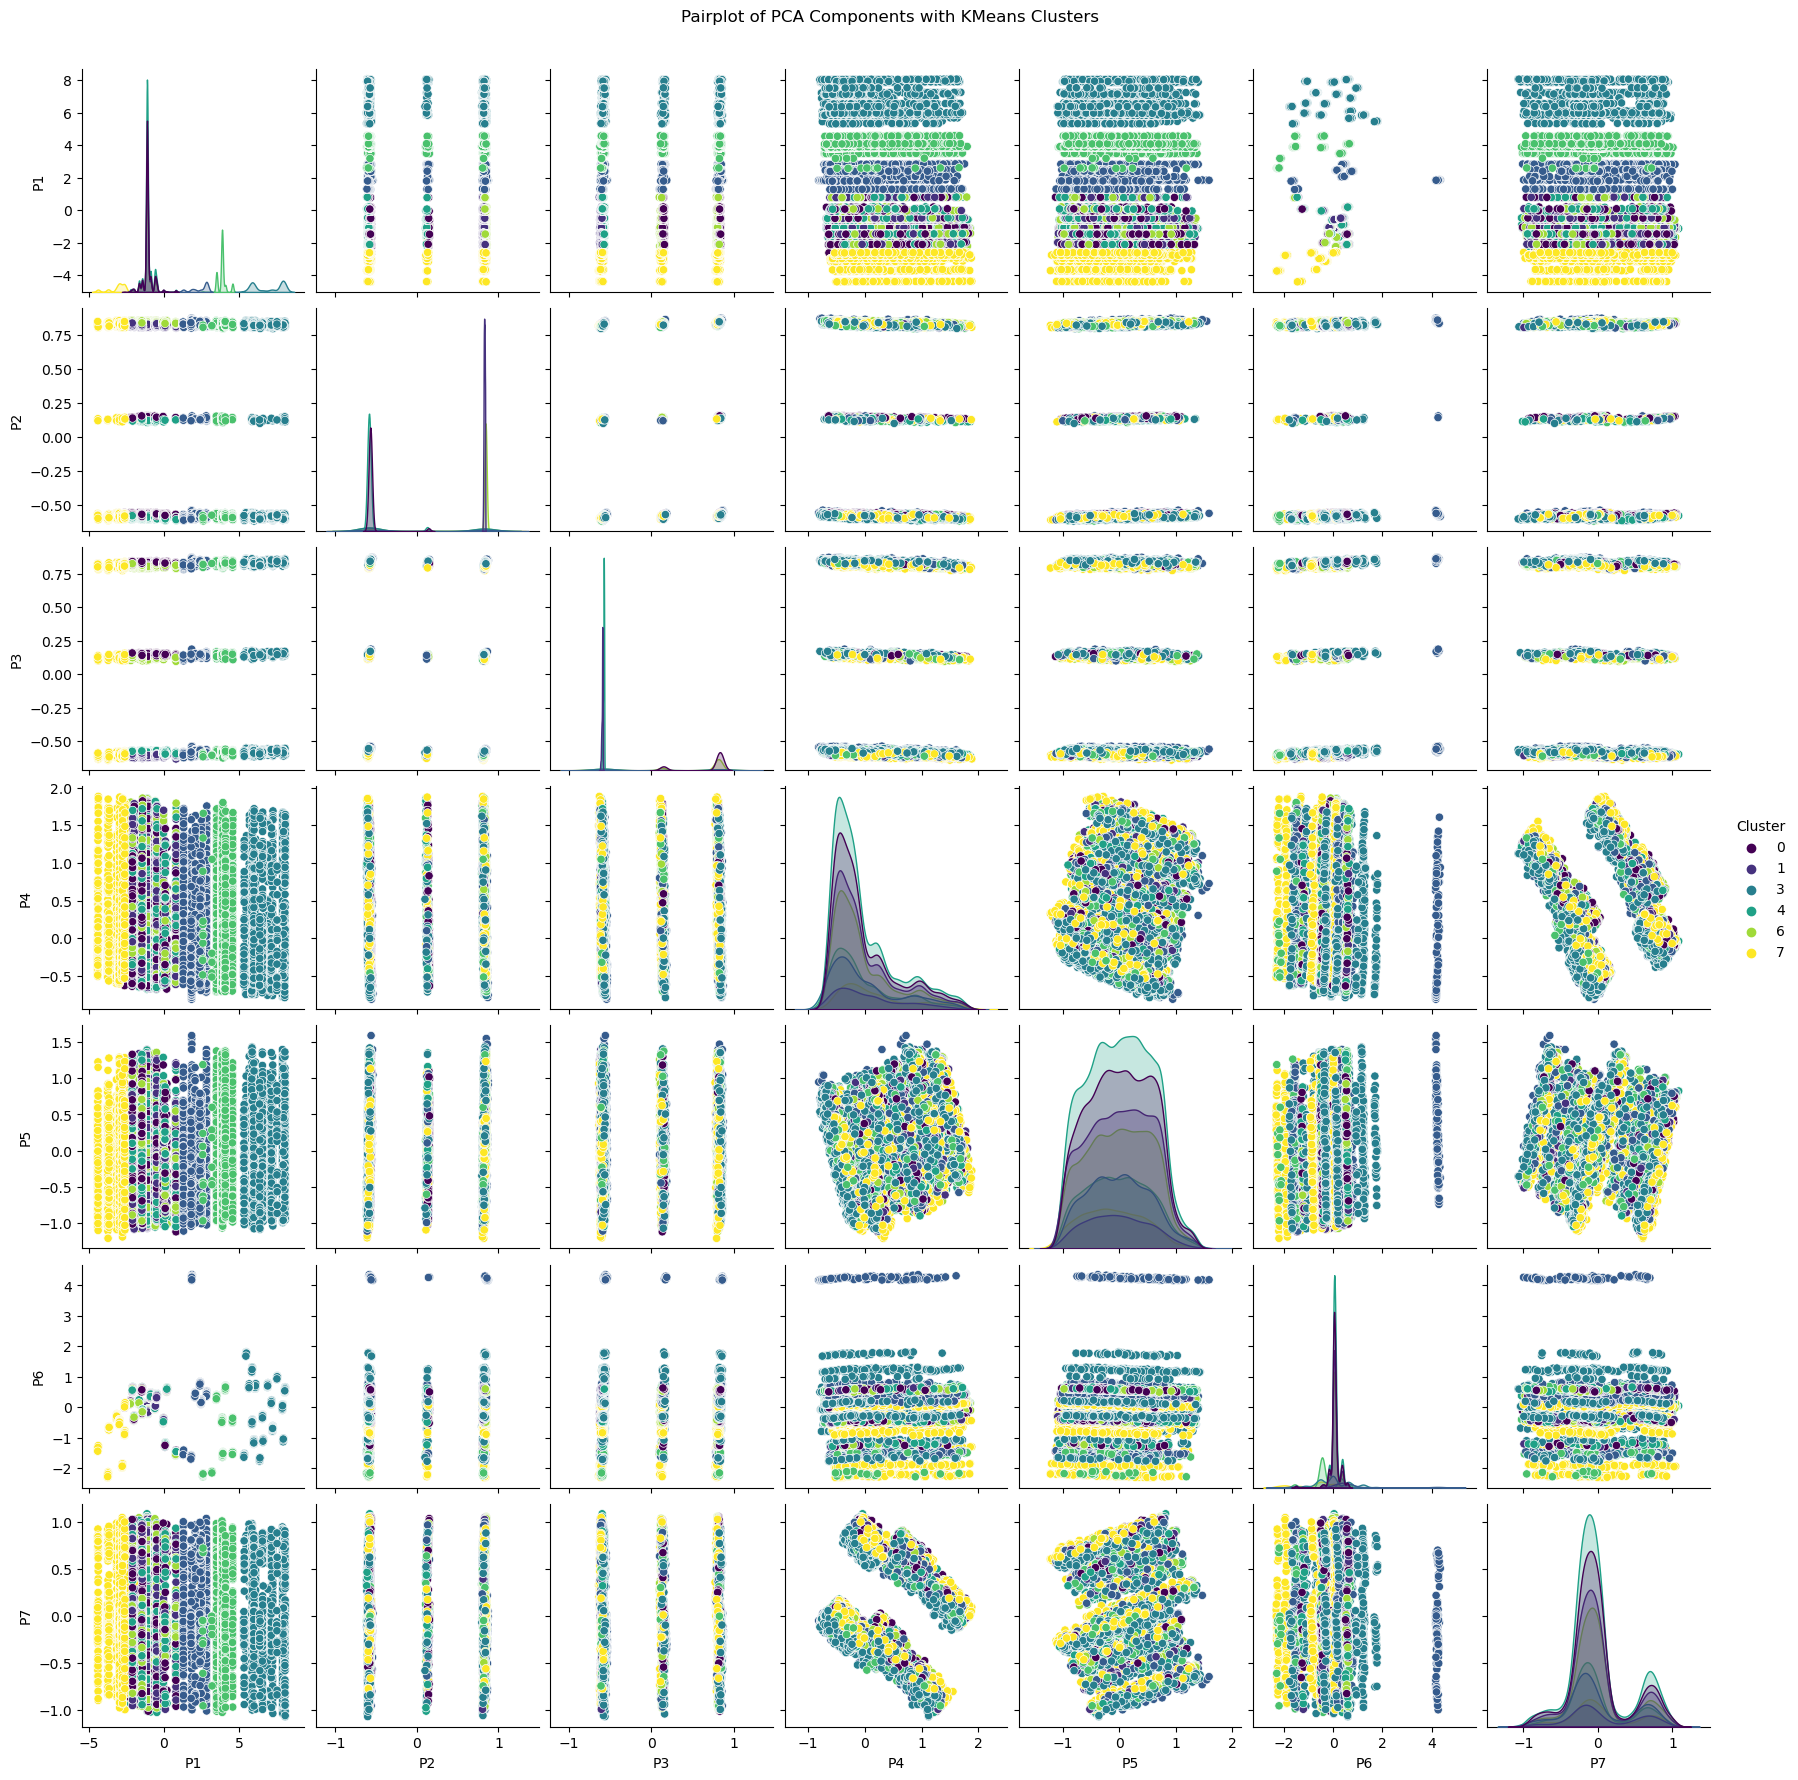

In [19]:
sns.pairplot(X_principal, hue='Cluster', palette='viridis')
plt.suptitle('Pairplot of PCA Components with KMeans Clusters', y=1.02)
plt.show()

### Cluster EDA

In [10]:
#colab
'''df = pd.read_parquet("/content/drive/MyDrive/BPI Clustering Project/cluster_analysis.parquet")
df.head()'''

#local
df = pd.read_parquet("cluster_analysis.parquet")
df.head()

EDUCATION   AGE    TENURE  BUSINESS_OWNER  DIGITAL_FLAG  \
CUST_NUM                                                                
13401.256807          1  23.0  1.295890               0             0   
4230.004965           0  22.0  8.205479               0             0   
4481.937304           0  23.0  7.073973               0             0   
4734.959768           0  23.0  3.468493               0             0   
4828.128416           1  23.0  4.857534               0             0   

             INCOME_SOURCE  SUBSEGMENT  GENDER MARITAL_STATUS  Frequency_cred  \
CUST_NUM                                                                        
13401.256807        SALARY           0    MALE         SINGLE              17   
4230.004965      ALLOWANCE           2    MALE         SINGLE              83   
4481.937304         SALARY           2  FEMALE         SINGLE              42   
4734.959768         SALARY           0  FEMALE         SINGLE              11   
4828.128416     REMITTANCE           1  FEMALE         SINGLE               1   

                AMOUNT_cred  Recency_cred   LATITUDE   LONGITUDE  
CUST_NUM                                                          
13401.256807    4987.052711            85  15.527737  120.419269  
4230.004965   131910.554528            85  14.608637  121.031947  
4481.937304    20333.322087            92  14.608637  121.031947  
4734.959768    49872.216089            92  14.608637  121.031947  
4828.128416     2130.039143           127  14.608637  121.031947

#### Assign Cluster column

In [11]:
df['Cluster'] = X_principal['Cluster'].values
df.head()

EDUCATION   AGE    TENURE  BUSINESS_OWNER  DIGITAL_FLAG  \
CUST_NUM                                                                
13401.256807          1  23.0  1.295890               0             0   
4230.004965           0  22.0  8.205479               0             0   
4481.937304           0  23.0  7.073973               0             0   
4734.959768           0  23.0  3.468493               0             0   
4828.128416           1  23.0  4.857534               0             0   

             INCOME_SOURCE  SUBSEGMENT  GENDER MARITAL_STATUS  Frequency_cred  \
CUST_NUM                                                                        
13401.256807        SALARY           0    MALE         SINGLE              17   
4230.004965      ALLOWANCE           2    MALE         SINGLE              83   
4481.937304         SALARY           2  FEMALE         SINGLE              42   
4734.959768         SALARY           0  FEMALE         SINGLE              11   
4828.128416     REMITTANCE           1  FEMALE         SINGLE               1   

                AMOUNT_cred  Recency_cred   LATITUDE   LONGITUDE  Cluster  
CUST_NUM                                                                   
13401.256807    4987.052711            85  15.527737  120.419269        0  
4230.004965   131910.554528            85  14.608637  121.031947        0  
4481.937304    20333.322087            92  14.608637  121.031947        6  
4734.959768    49872.216089            92  14.608637  121.031947        6  
4828.128416     2130.039143           127  14.608637  121.031947        6

#### Cluster Distribution

<Axes: xlabel='Cluster', ylabel='count'>

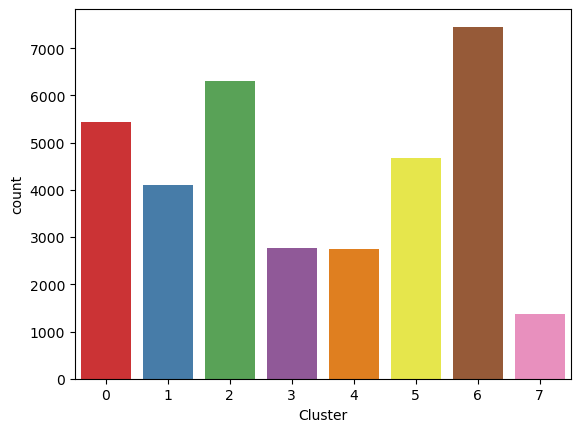

In [12]:
sns.countplot(x=df['Cluster'], palette='Set1')

#### Pairplot

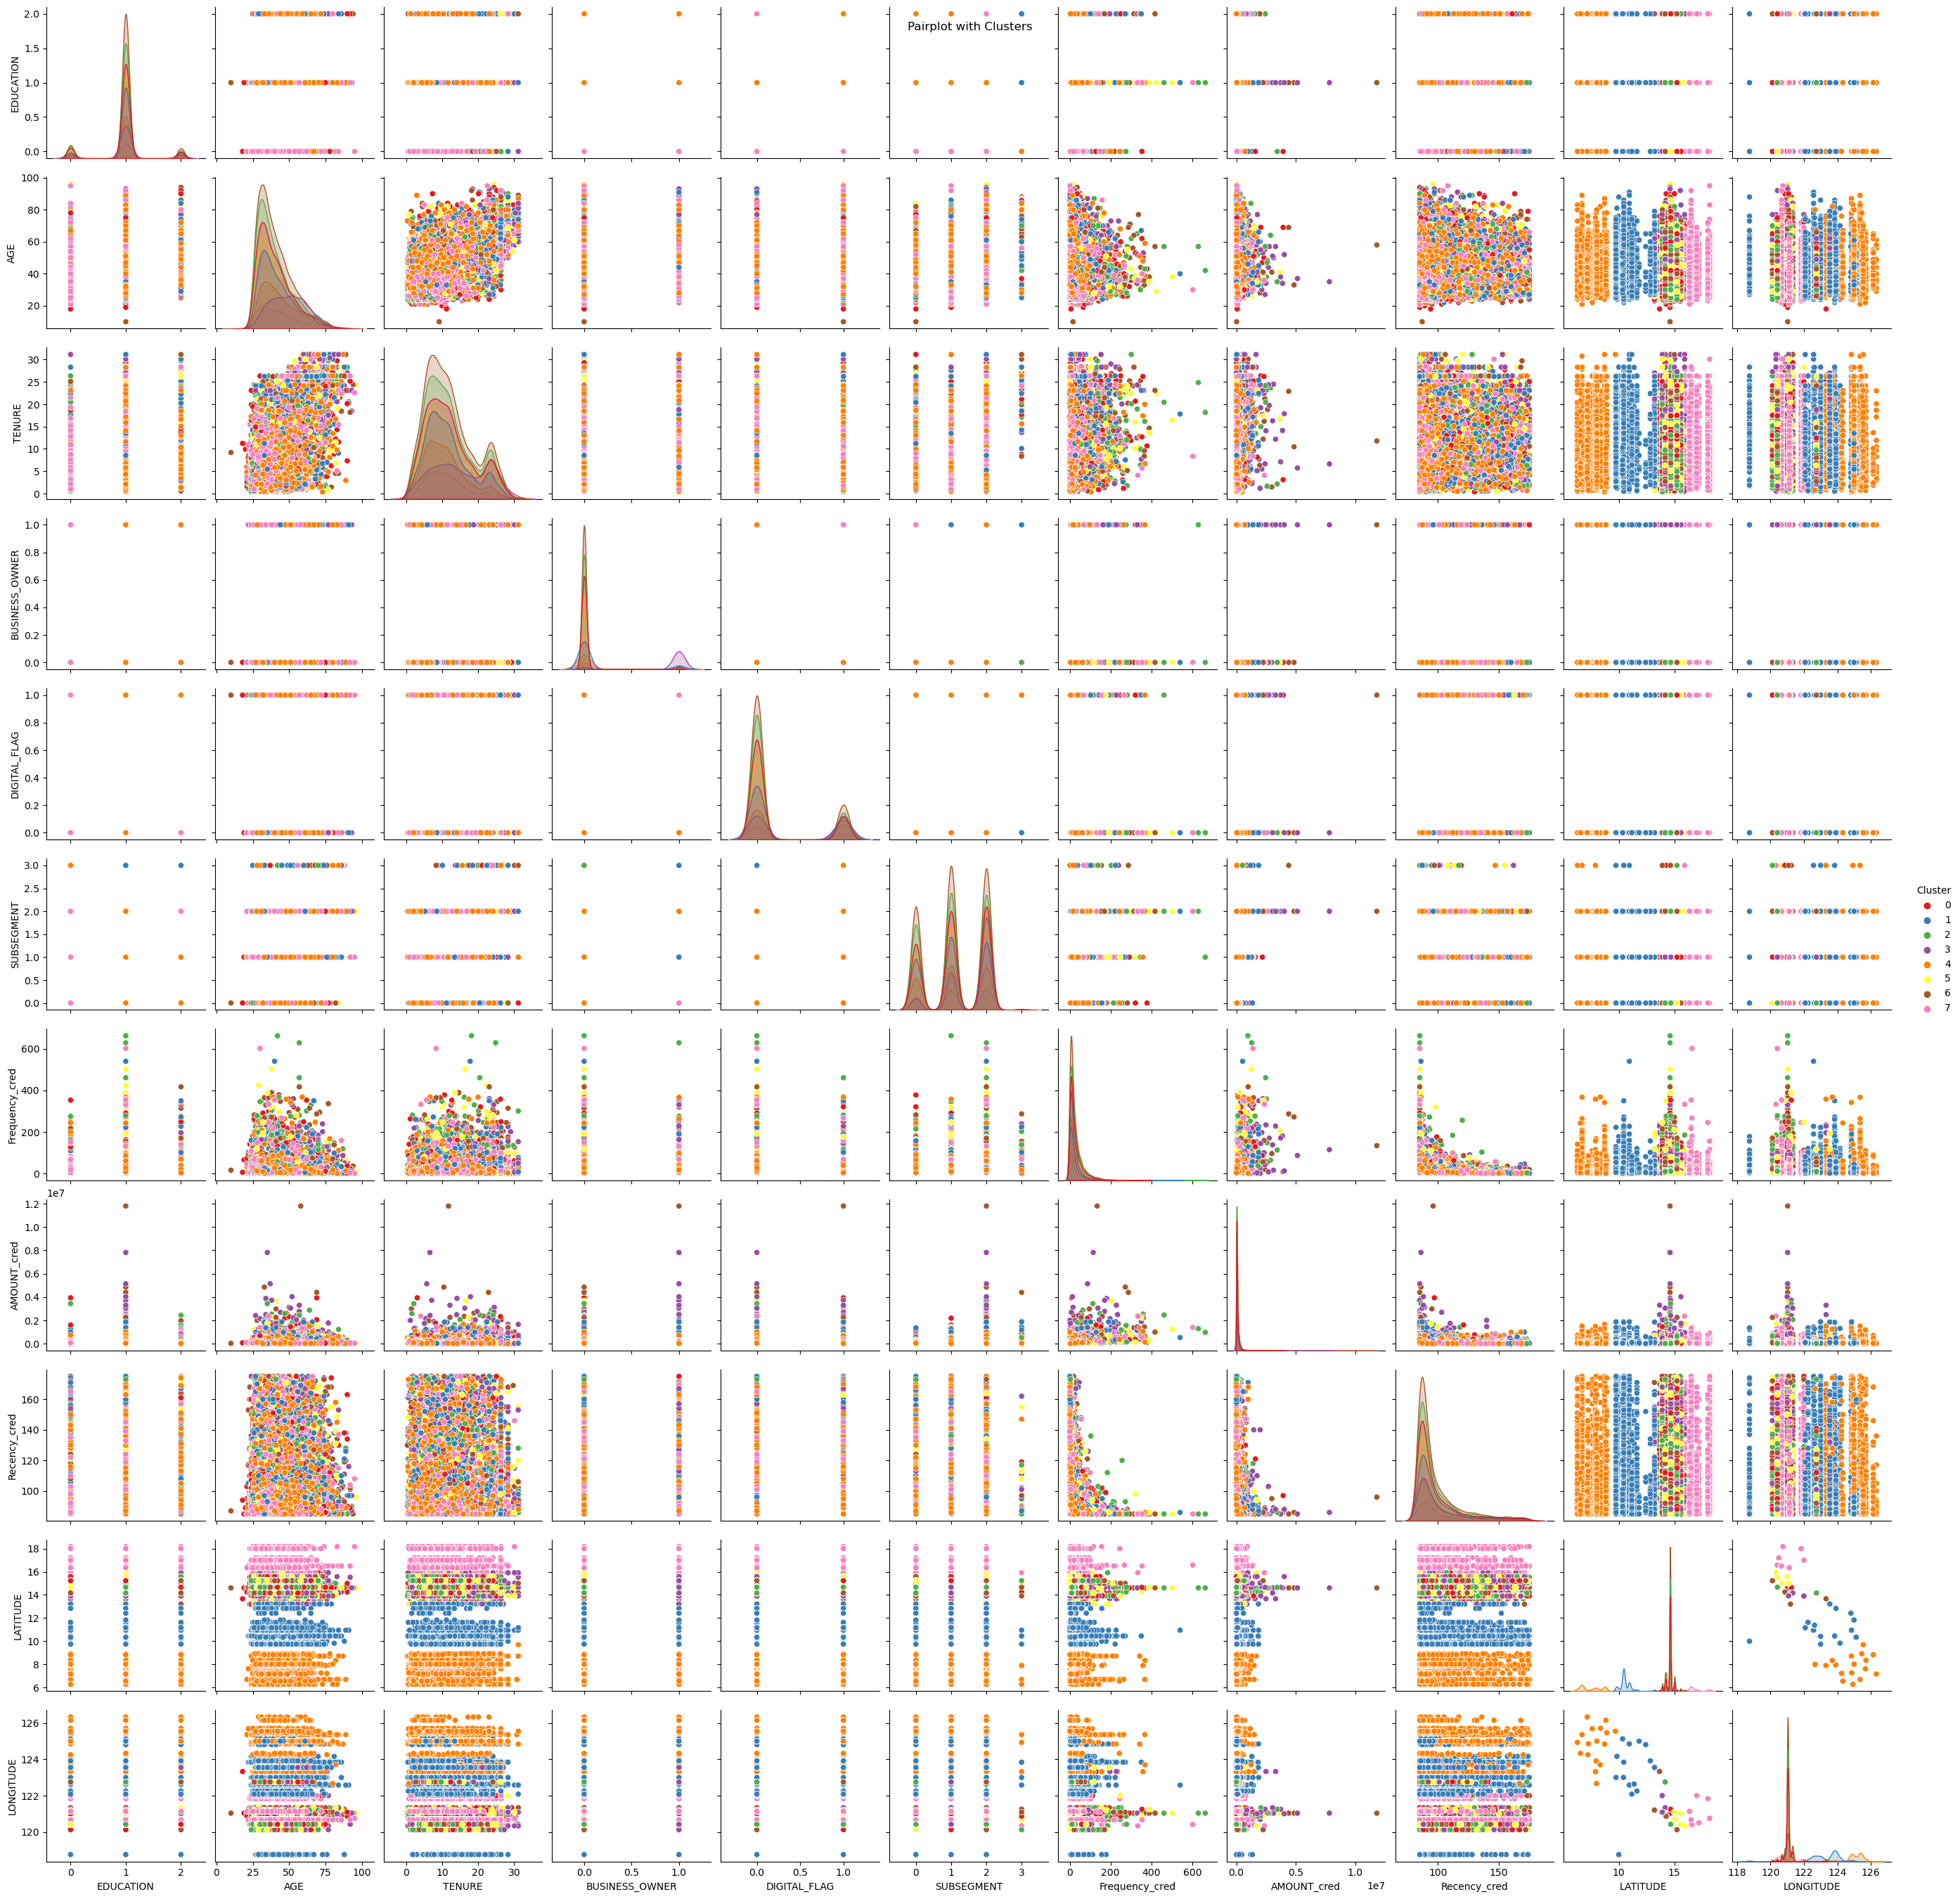

In [13]:
# Plotting pairplot with hue as clusters
sns.pairplot(df, hue='Cluster', palette='Set1')
plt.suptitle('Pairplot with Clusters')
plt.show()

#### Define clusters

In [23]:
clusters = []
for i in range(N):
    exec('cluster_{k} = df[df[\'Cluster\'] == {k}]'.format(k = i))
    exec('clusters.append(cluster_{k})'.format(k = i))

#### Histograms

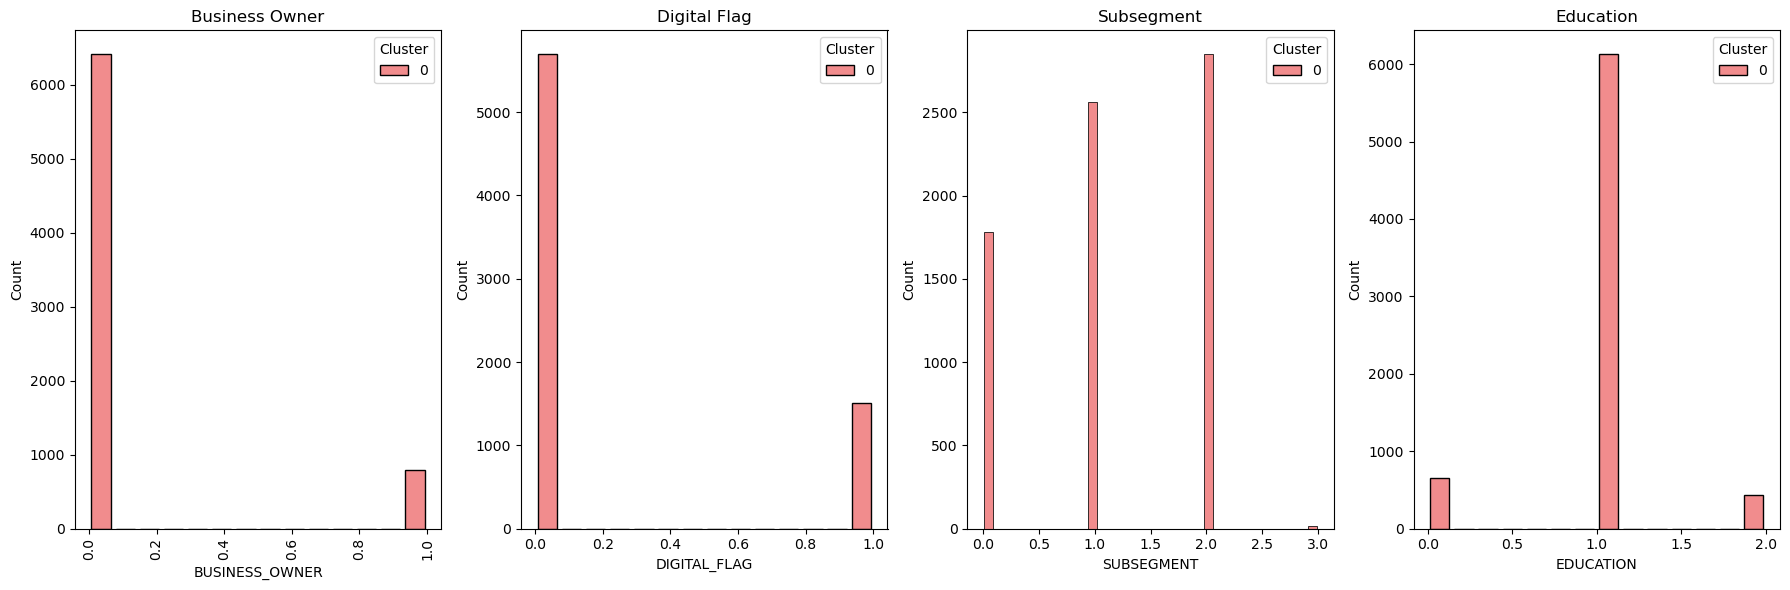

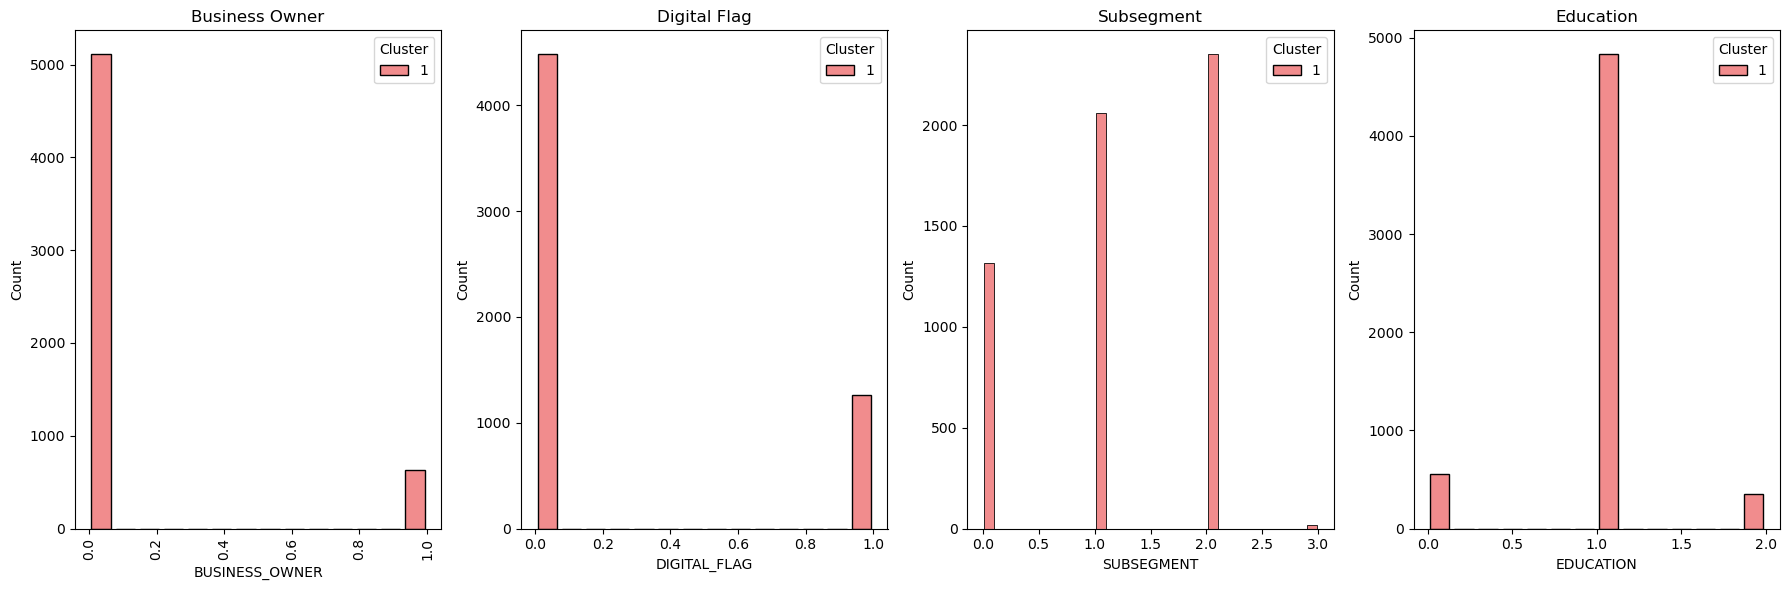

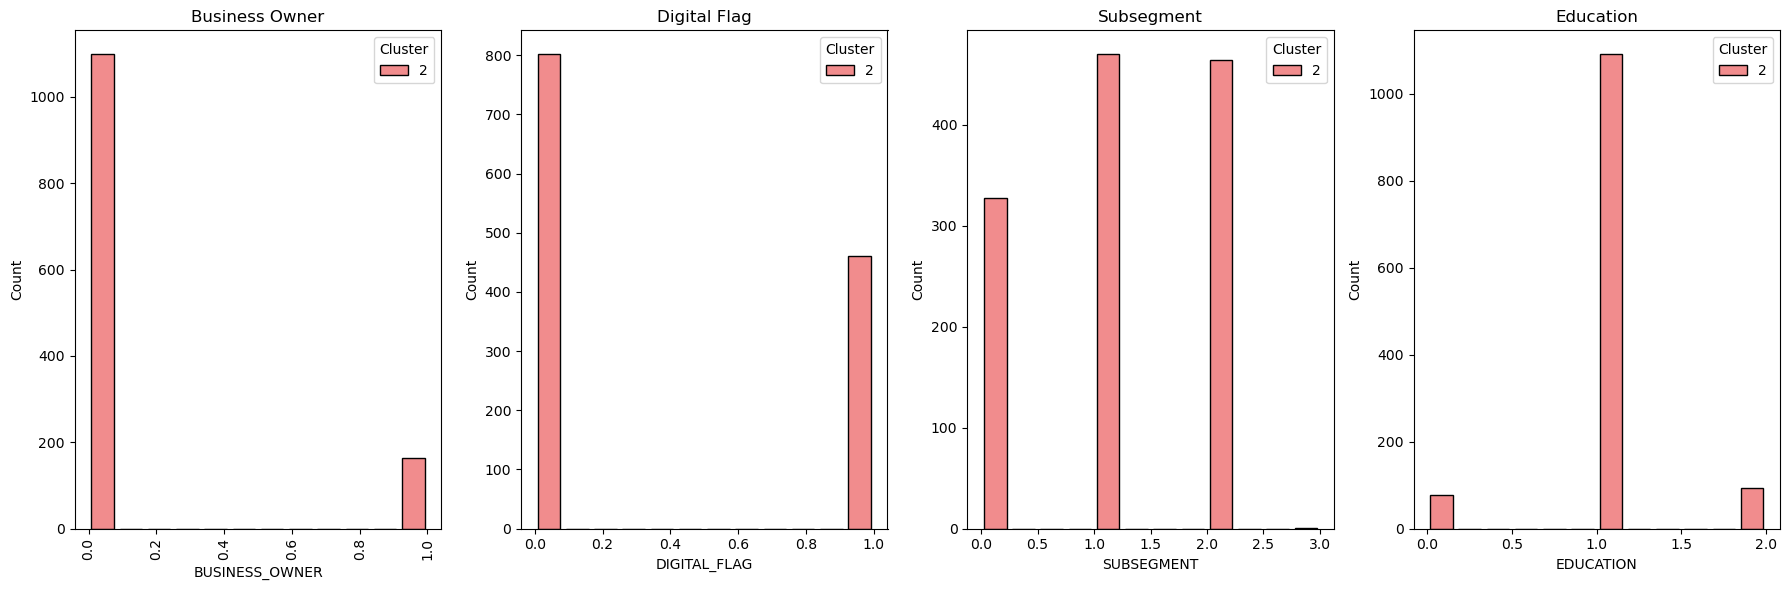

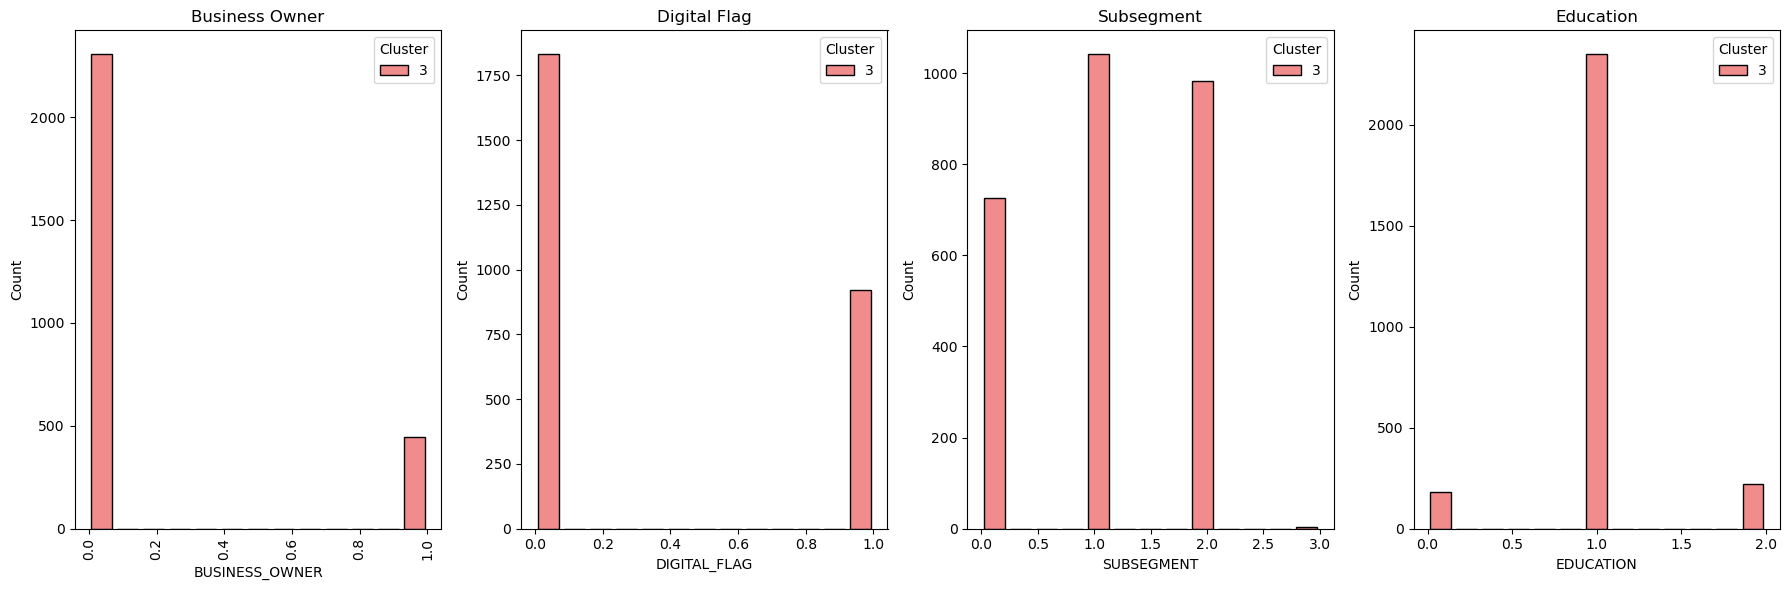

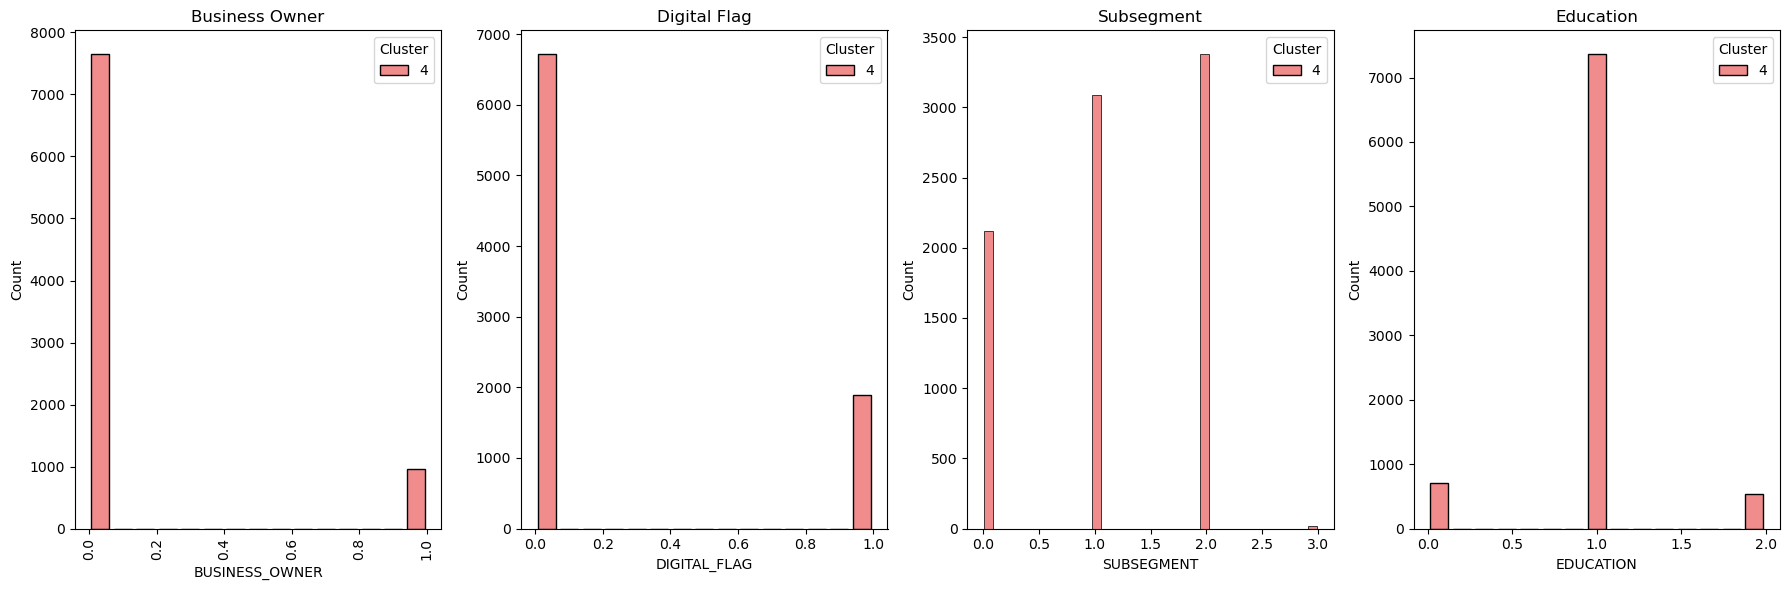

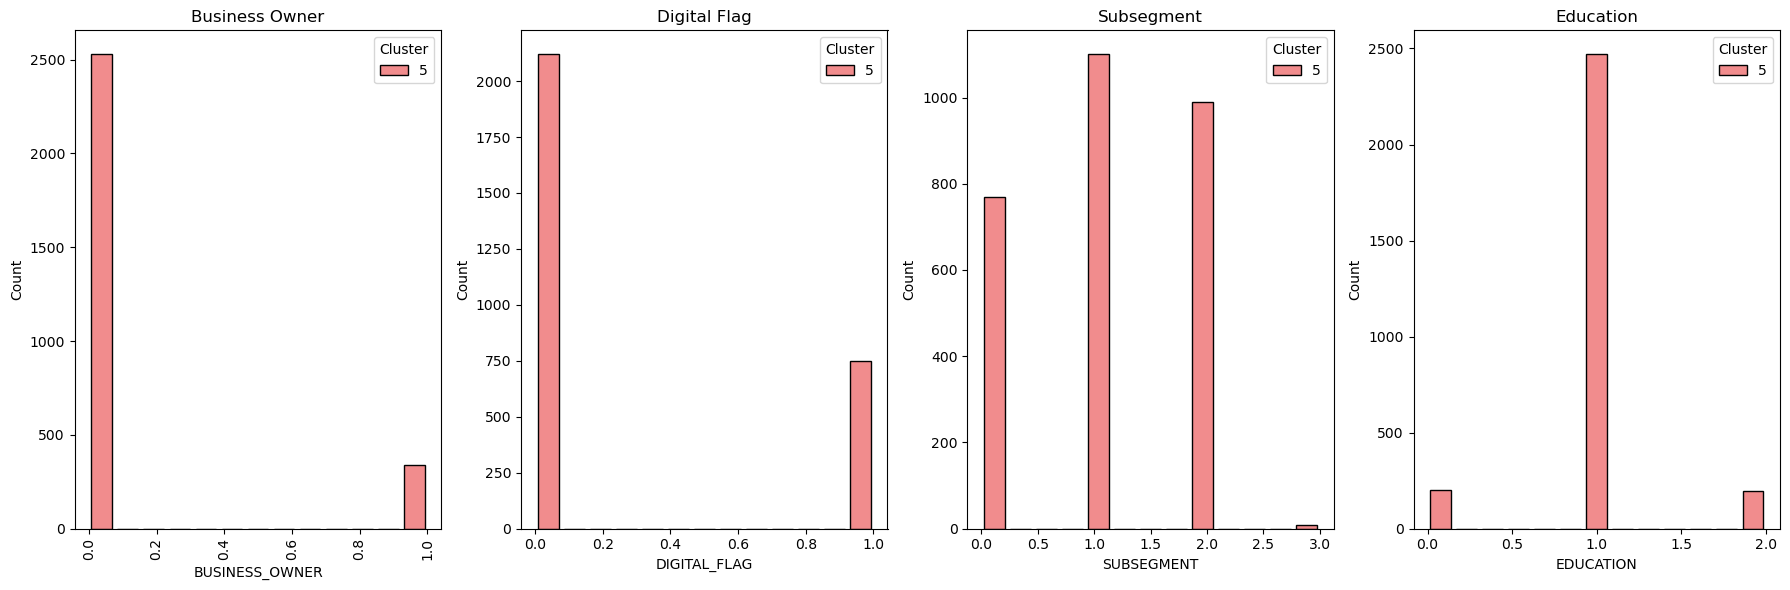

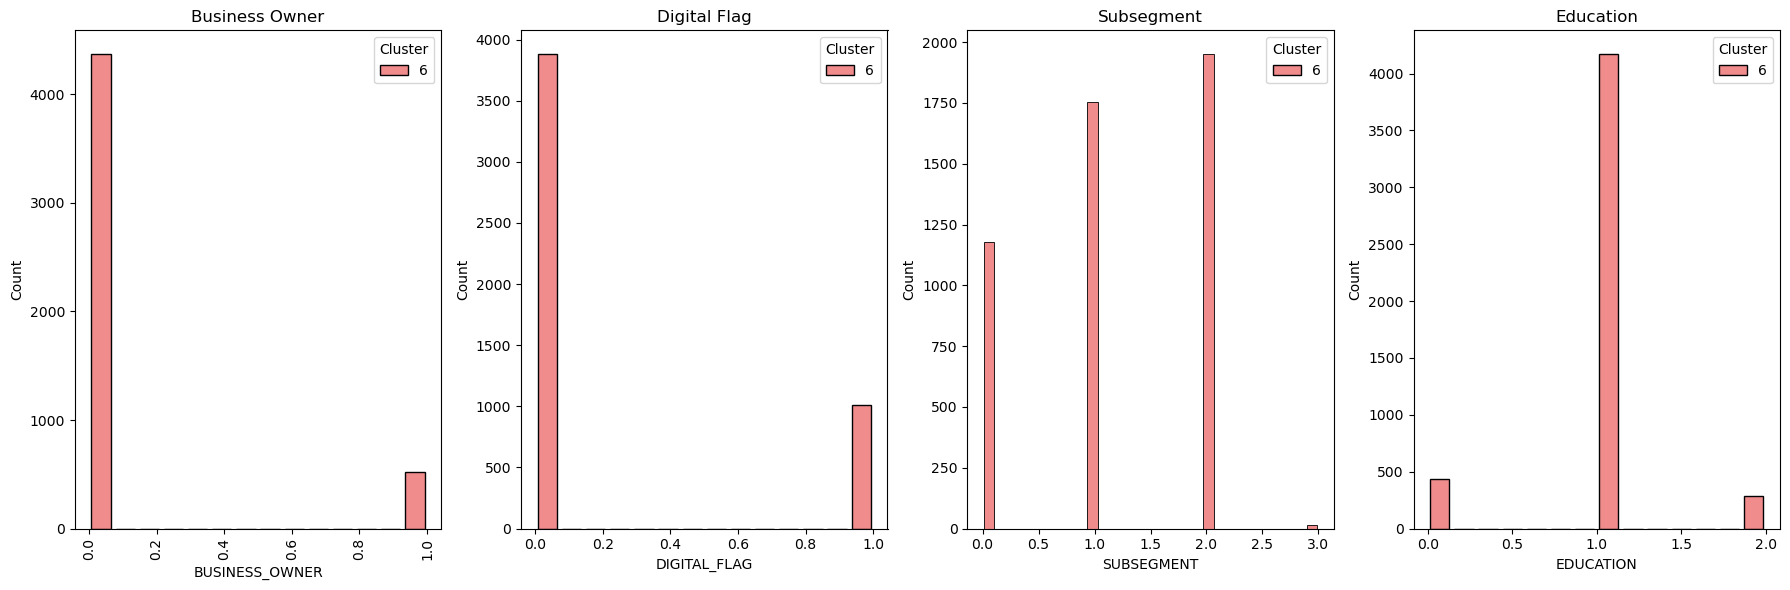

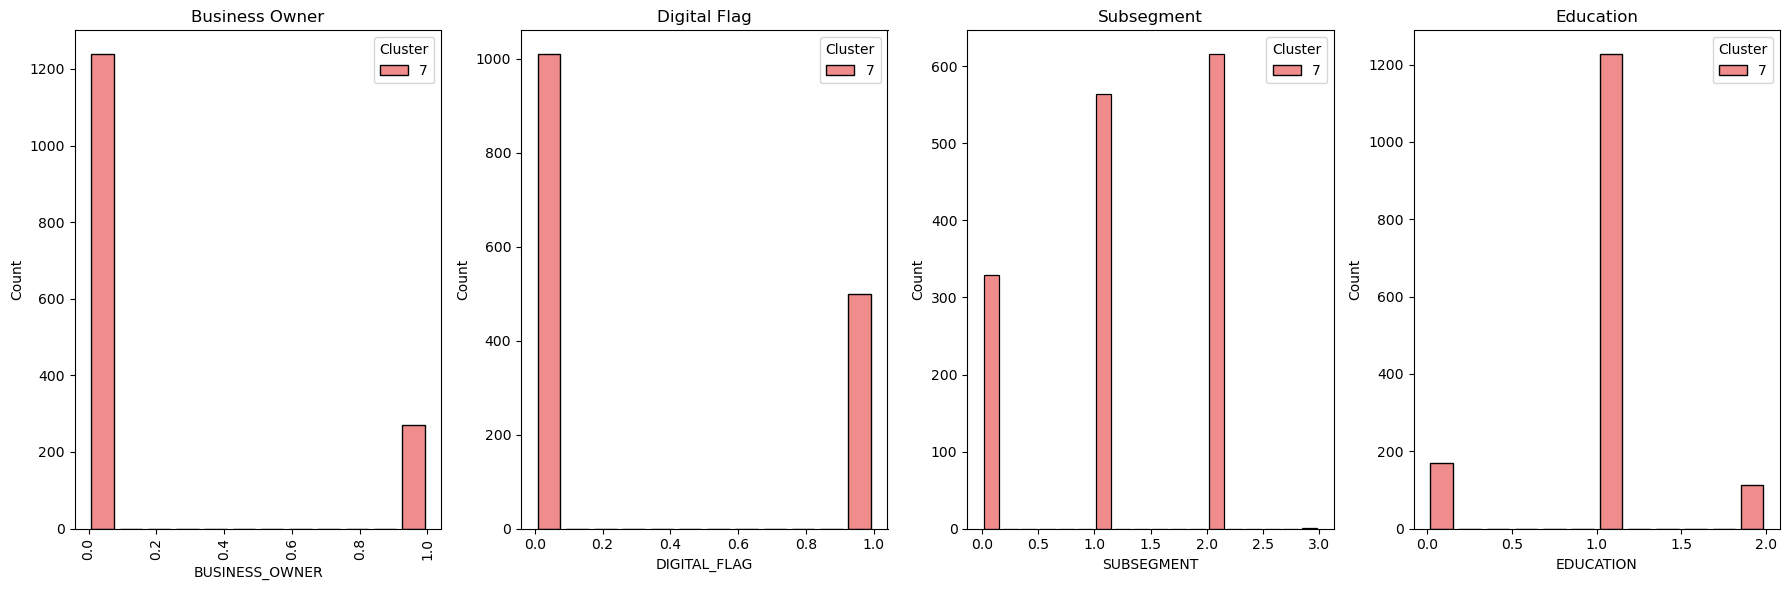

In [24]:
for i in clusters:
    
    # Create a figure and axis for subplots
    fig, axes = plt.subplots(1, 4, figsize=(18, 6))
    
    # Plotting histograms for each categorical variable
    sns.histplot(i, x='BUSINESS_OWNER', hue='Cluster', ax=axes[0], palette='Set1', shrink=0.8)
    axes[0].set_title('Business Owner')
    axes[0].tick_params(axis='x', rotation=90)
    
    sns.histplot(i, x='DIGITAL_FLAG', hue='Cluster', ax=axes[1], palette='Set1', shrink=0.8)
    axes[1].set_title('Digital Flag')
    
    sns.histplot(i, x='SUBSEGMENT', hue='Cluster', ax=axes[2], palette='Set1', shrink=0.8)
    axes[2].set_title('Subsegment')
    
    sns.histplot(i, x='EDUCATION', hue='Cluster', ax=axes[3], palette='Set1', shrink=0.8)
    axes[3].set_title('Education')
    # Adjust layout
    
    plt.tight_layout()
    plt.show()

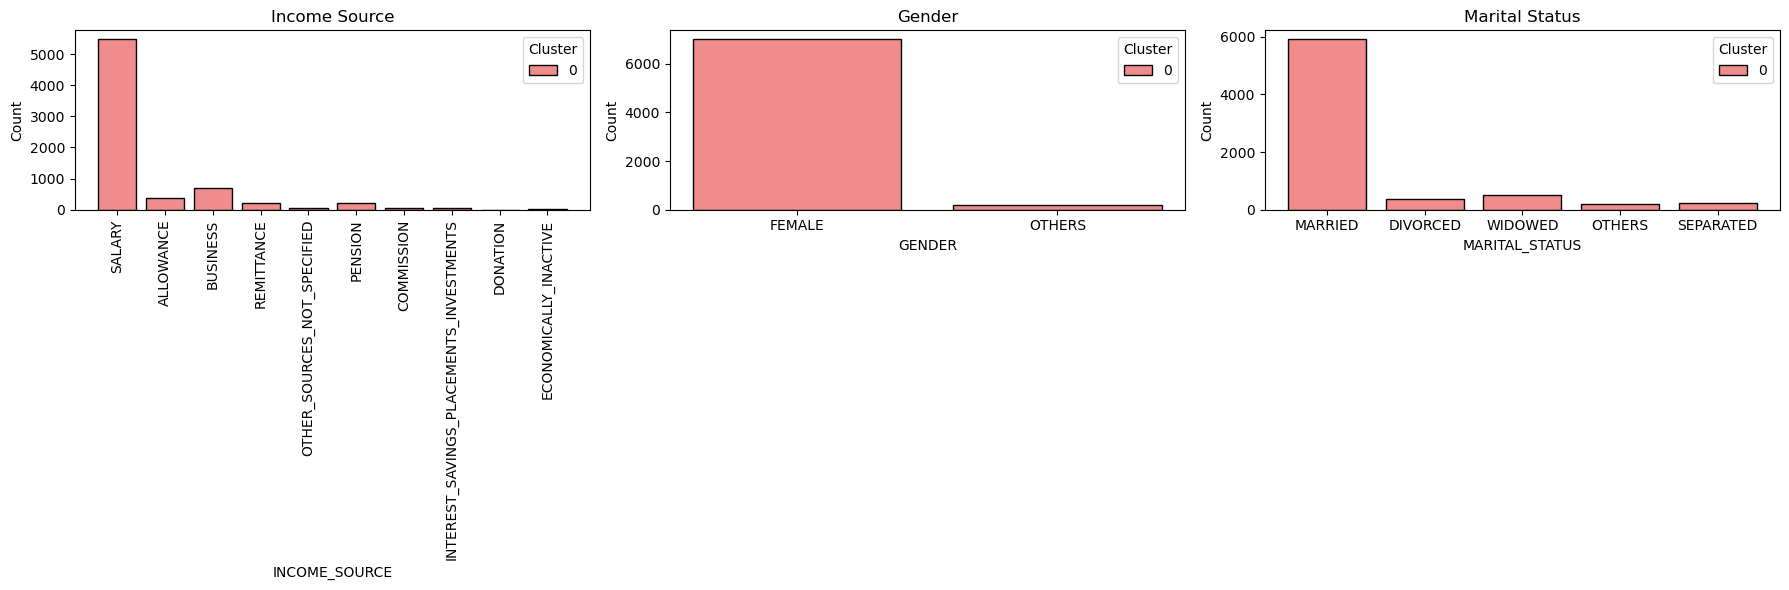

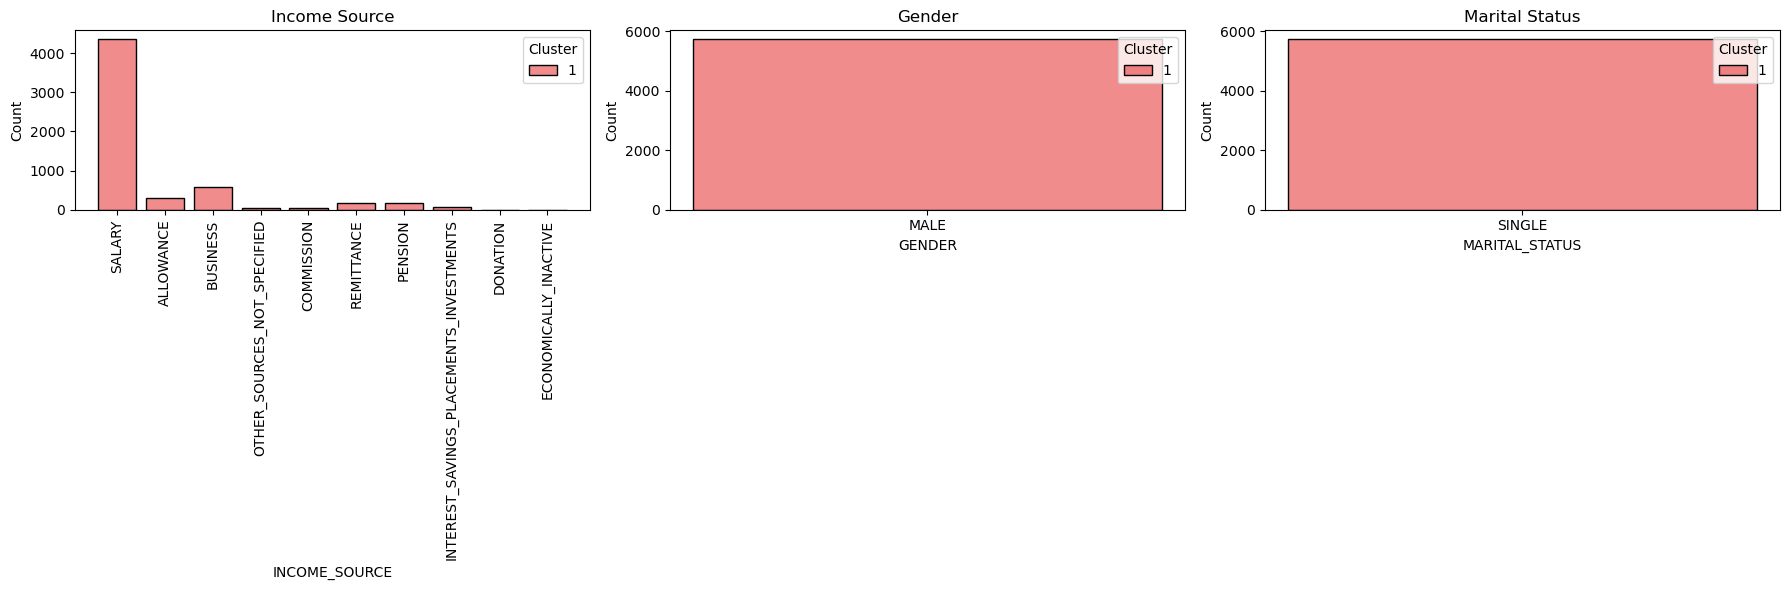

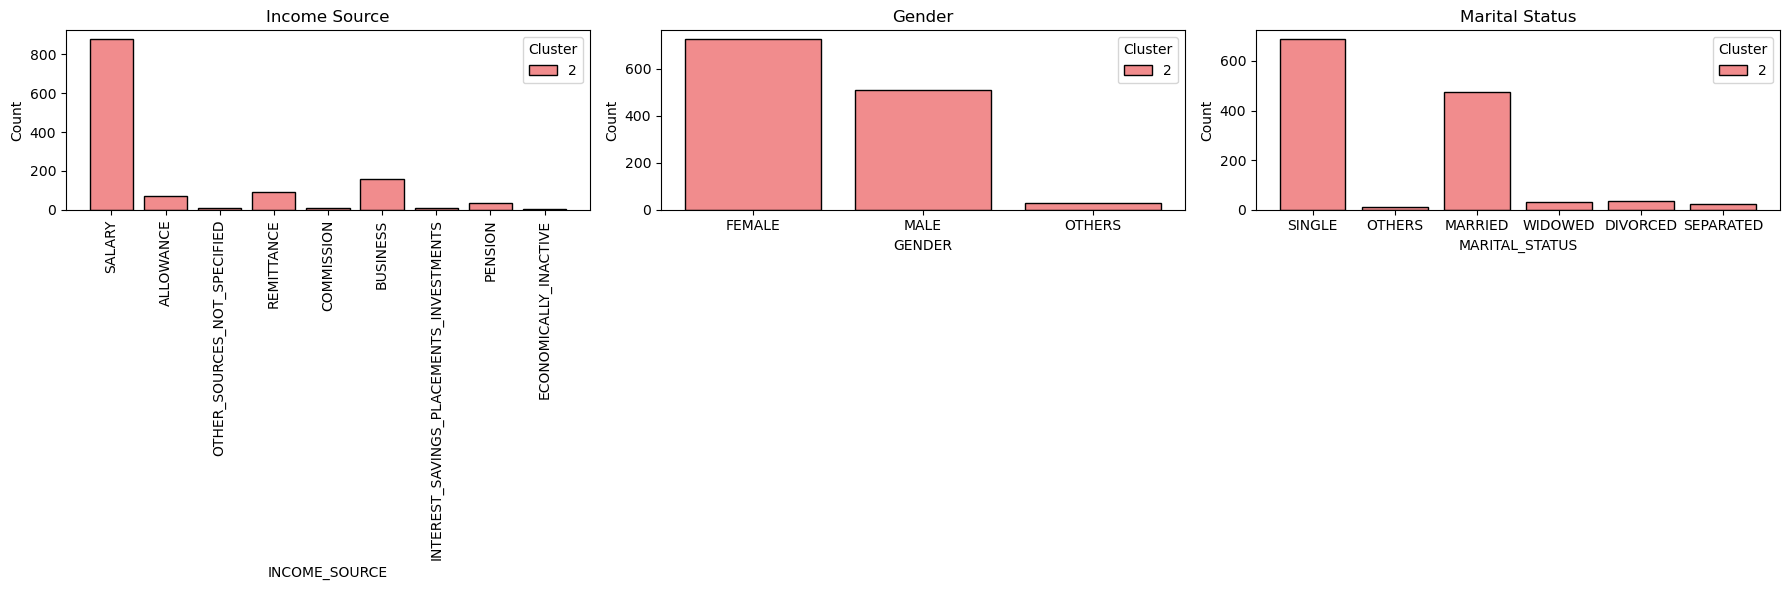

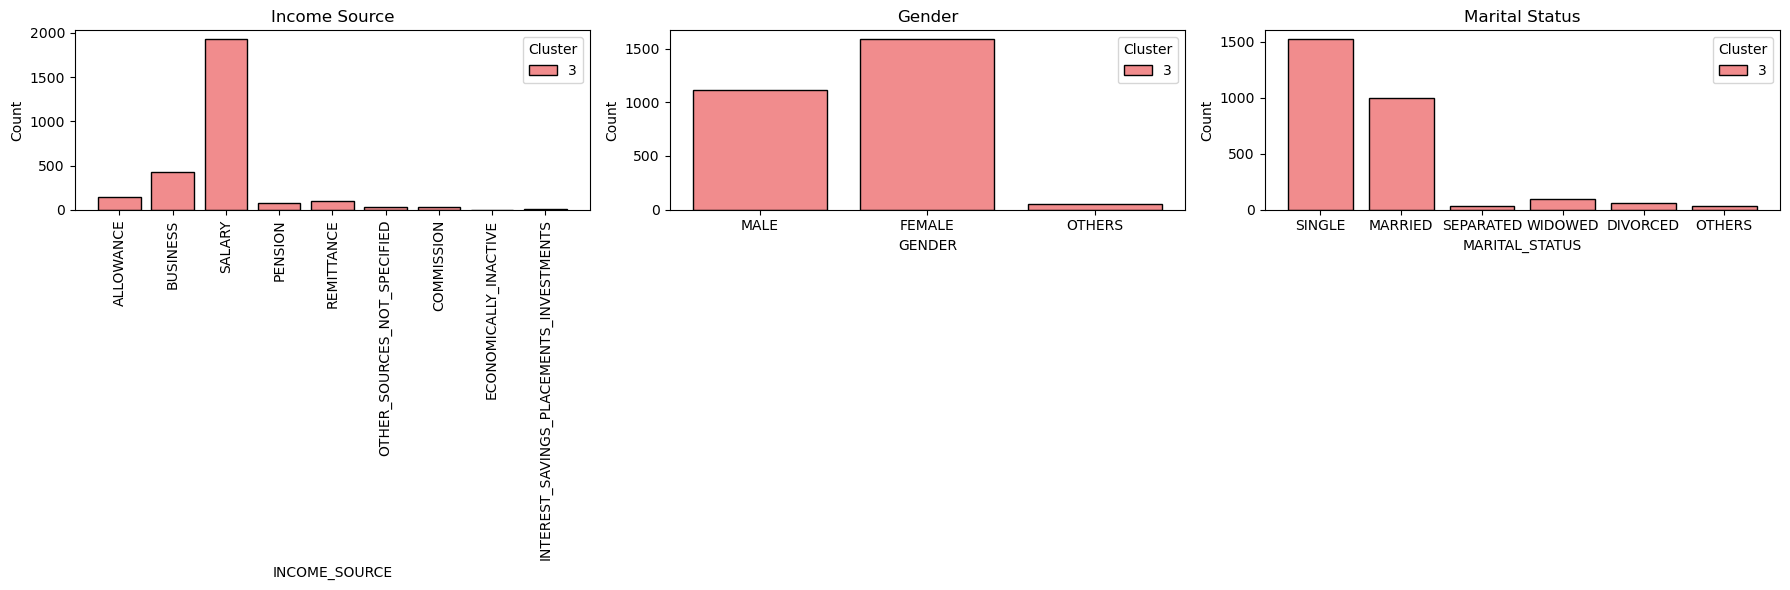

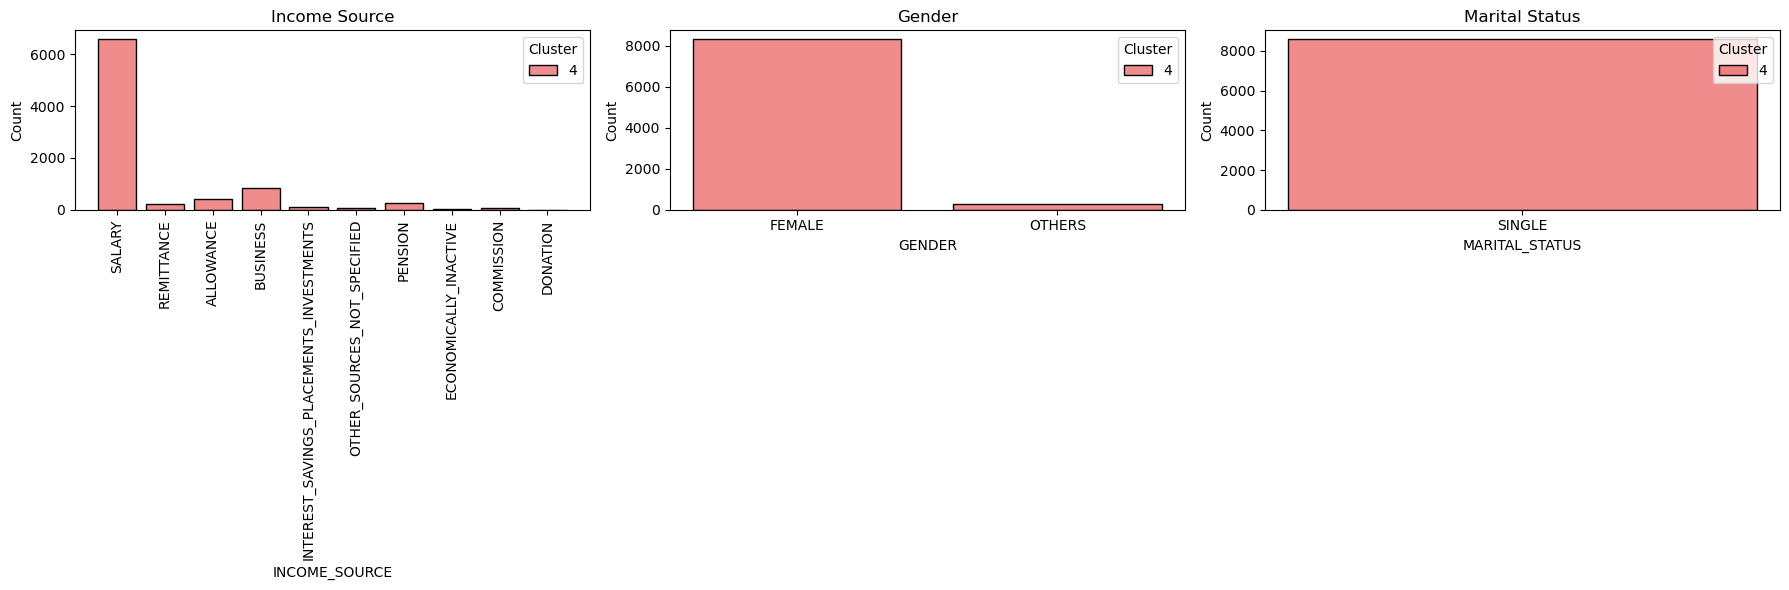

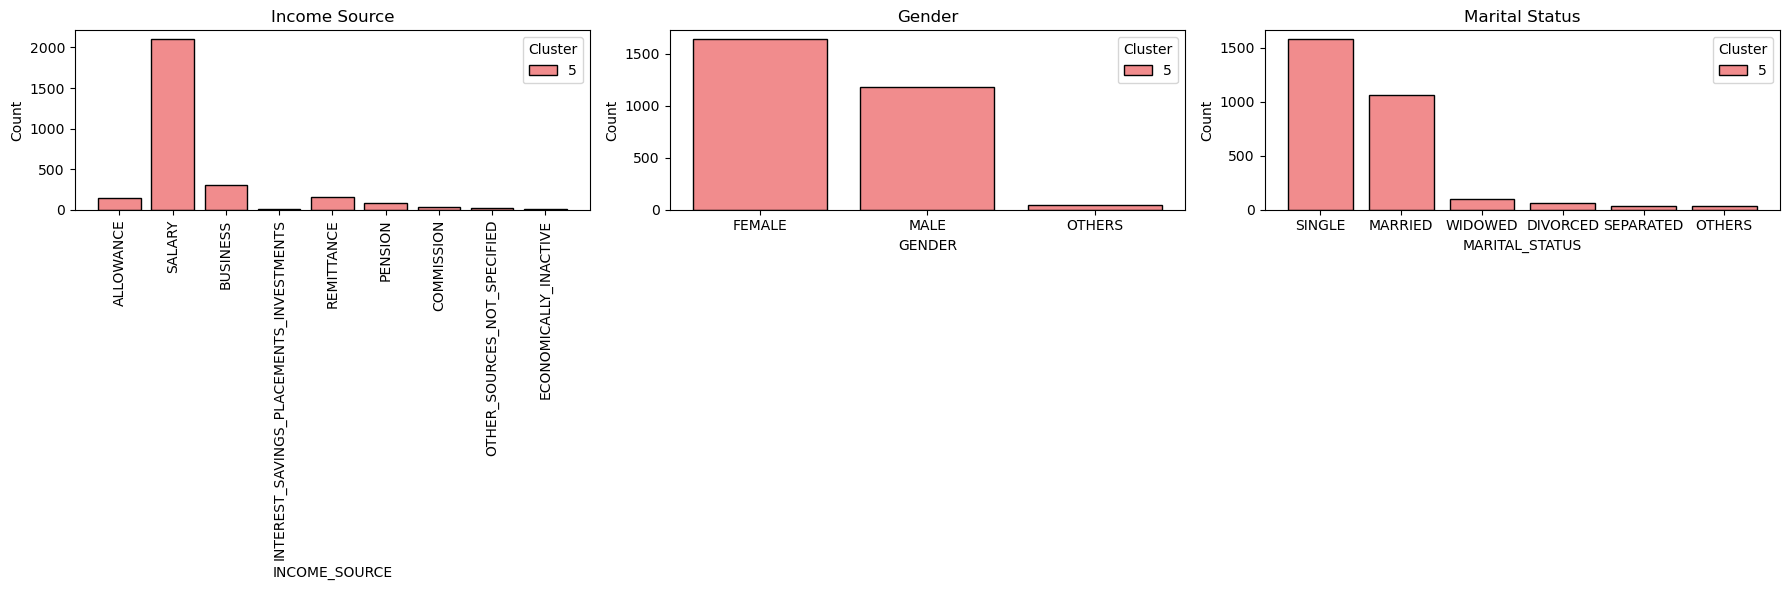

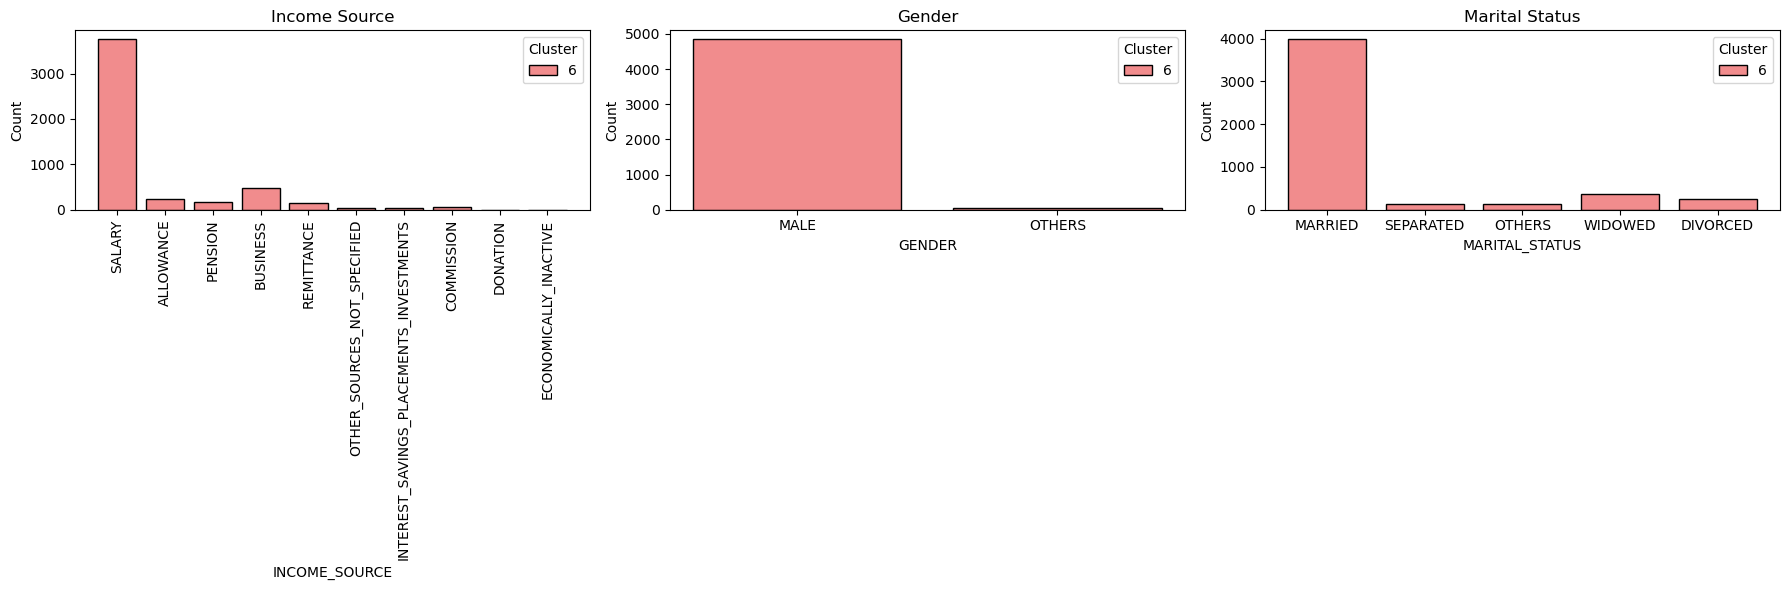

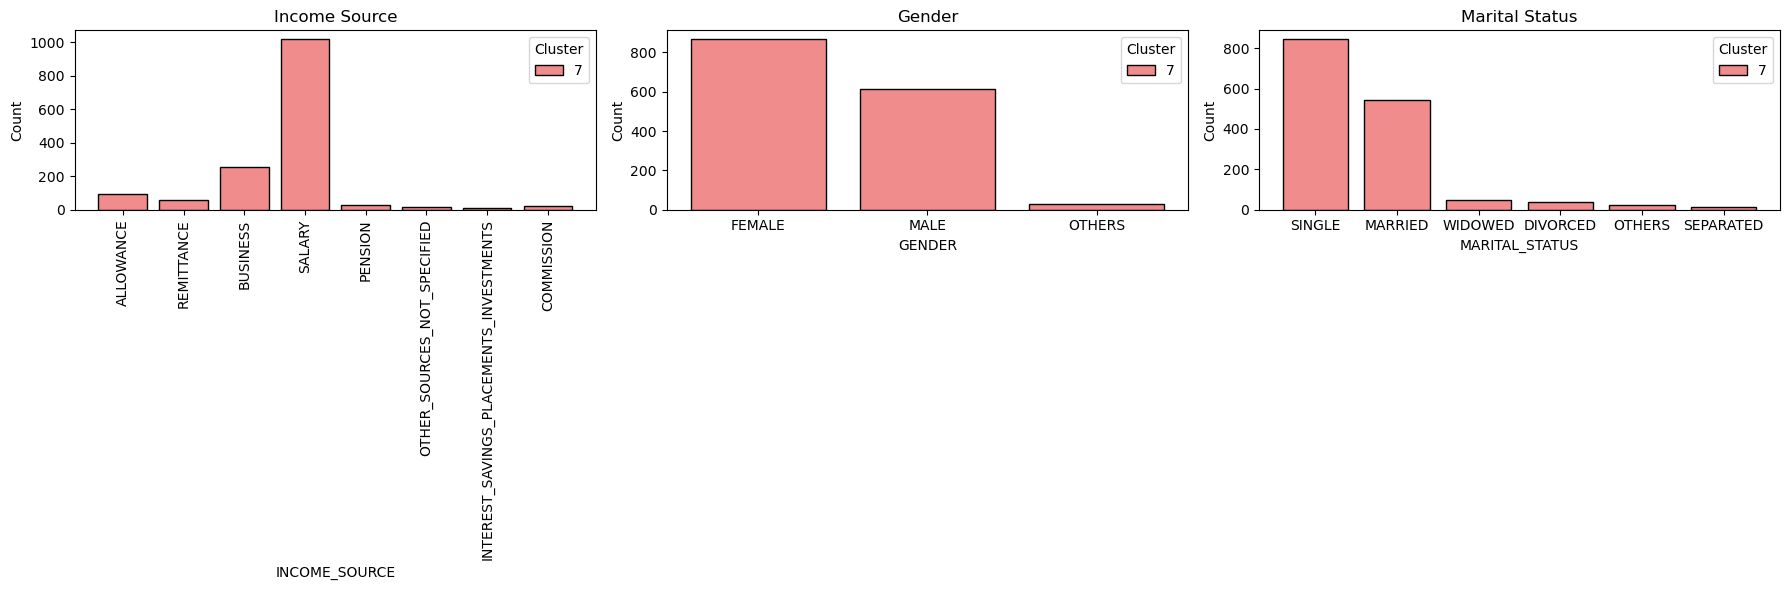

In [25]:
for i in clusters:
    
    # Create a figure and axis for subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Plotting histograms for each categorical variable
    sns.histplot(i, x='INCOME_SOURCE', hue='Cluster', ax=axes[0], palette='Set1', shrink=0.8)
    axes[0].set_title('Income Source')
    axes[0].tick_params(axis='x', rotation=90)
    
    sns.histplot(i, x='GENDER', hue='Cluster', ax=axes[1], palette='Set1', shrink=0.8)
    axes[1].set_title('Gender')
    
    sns.histplot(i, x='MARITAL_STATUS', hue='Cluster', ax=axes[2], palette='Set1', shrink=0.8)
    axes[2].set_title('Marital Status')
    
    # Adjust layout
    
    plt.tight_layout()
    plt.show()